## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [102 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [102 kB]      
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [102 kB]     
Fetched 305 kB in 1s (340 kB/s)                            
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libatlas-base-dev is already the newest version (3.10.3-5).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(2, 3):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:38<00:00,  3.58it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_2"])
layer_hs_array.shape

(10000, 267264)

## Layer 2 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 3.89 s
Outer iteration 0 / 10
  Iteration 19 (10.97 s, search 7.31 s): objective=1933.05 imbalance=1.090 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (21.92 s, search 14.59 s): objective=1933.02 imbalance=1.118 nsplit=0       
Outer iteration 2 / 10
  Iteration 19 (32.89 s, search 21.88 s): objective=1926.5 imbalance=1.033 nsplit=0        
Outer iteration 3 / 10
  Iteration 19 (43.85 s, search 29.18 s): objective=1932.21 imbalance=1.122 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (54.82 s, search 36.48 s): objective=1927.68 imbalance=1.262 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (65.79 s, search 43.79 s): objective=1923.89 imbalance=1.093 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (76.76 s, search 51.08 s): objective=1933.16 imbalance=1.127 nsplit=0       
Objectiv

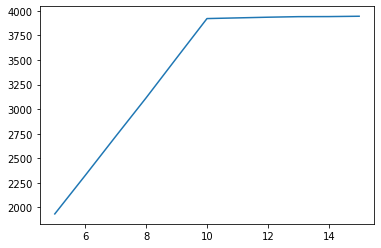

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.12 s
Outer iteration 0 / 10
  Iteration 19 (22.03 s, search 14.70 s): objective=3904.32 imbalance=1.399 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (44.12 s, search 29.42 s): objective=3909.43 imbalance=1.155 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (66.20 s, search 44.16 s): objective=3910.24 imbalance=1.239 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (88.28 s, search 58.89 s): objective=3914.18 imbalance=1.074 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (110.39 s, search 73.63 s): objective=3884.97 imbalance=2.140 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (132.43 s, search 88.33 s): objective=3917.73 imbalance=1.120 nsplit=0       
Objective improved: keep new clusters
Outer iterat

3921.579345703125

In [15]:
kmeans.centroids #cluster centers

array([[ 5.4099518e-03,  2.9054026e-03,  1.3524321e-02, ...,
         2.6181377e-07, -6.1106107e-08,  4.3653772e-06],
       [ 6.1436254e-03,  3.2994193e-03,  1.5358436e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.2049314e-03,  2.7952981e-03,  1.3011818e-02, ...,
         2.5200737e-08, -1.5889553e-06, -1.8946595e-06],
       ...,
       [ 5.5959127e-03,  3.0052708e-03,  1.3989202e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.2332487e-03,  2.8104987e-03,  1.3082581e-02, ...,
        -8.3596831e-07,  1.1503711e-05,  3.6611855e-05],
       [ 6.1052456e-03,  3.2788084e-03,  1.5262492e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000451
1.0000119
1.0000347
1.0000099
1.0000281
1.0000126
1.0000145
1.0000482
1.0000352
1.0000373


In [17]:
kmeans.obj #inertia at each iteration

array([2521.53613281, 3765.8984375 , 3836.37353516, 3861.5012207 ,
       3875.42431641, 3885.79907227, 3894.38183594, 3899.83398438,
       3902.55688477, 3903.68212891, 3904.03857422, 3904.17016602,
       3904.25048828, 3904.27368164, 3904.29199219, 3904.30200195,
       3904.31005859, 3904.30810547, 3904.31054688, 3904.31567383,
       2583.67700195, 3772.03125   , 3807.9375    , 3848.27783203,
       3873.06982422, 3890.10644531, 3897.203125  , 3901.01269531,
       3903.54492188, 3904.77050781, 3905.44360352, 3905.89648438,
       3906.25512695, 3906.77490234, 3907.38964844, 3908.09399414,
       3908.61474609, 3908.97265625, 3909.23754883, 3909.43286133,
       2479.12231445, 3759.81933594, 3809.27734375, 3843.45483398,
       3860.03198242, 3873.20776367, 3888.01391602, 3895.33813477,
       3898.70019531, 3900.89770508, 3902.46630859, 3903.66064453,
       3904.90332031, 3906.42504883, 3907.79760742, 3908.70019531,
       3909.20947266, 3909.63916016, 3909.94897461, 3910.24487

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

0    1065
4    1060
7    1058
3    1004
1     979
5     889
2     623
9     505
8     460
6     357
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[5, 1, 9, 5, 2, 6, 10, 6, 10, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 5, 1: 1, 2: 9, 3: 5, 4: 2, 5: 6, 6: 10, 7: 6, 8: 10, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 5,  9,  9, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.28
Prompt 2 Accuracy:  0.265
Prompt 3 Accuracy:  0.52125
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.90375
Prompt 6 Accuracy:  0.49625
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.24
Prompt 10 Accuracy:  0.98


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.368625


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

1    266
7    262
0    259
3    255
4    252
5    216
2    169
8    120
9    118
6     83
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 1,  9,  5, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.305
Prompt 2 Accuracy:  0.205
Prompt 3 Accuracy:  0.53
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.92
Prompt 6 Accuracy:  0.495
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.29
Prompt 10 Accuracy:  0.99


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.3735


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

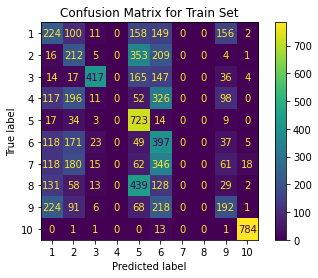

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

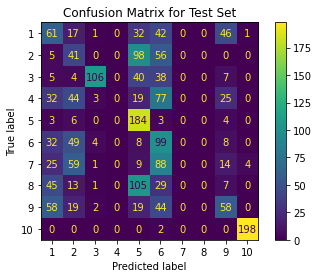

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()